In [2]:
import os
import time
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from skimage.morphology import label
from skimage.data import imread

In [3]:
# CONFIG

SHIP_CLASS_NAME = 'ship'
IMAGE_WIDTH     = 768
IMAGE_HEIGHT    = 768
SHAPE           = (IMAGE_WIDTH, IMAGE_HEIGHT)
WORKING_DIR     = '/home/jupyter/'
INPUT_DIR       = '/home/jupyter/Data/input'
OUTPUT_DIR      = '/home/jupyter/Data/output'

TRAINING_VALIDATION_RATIO = 0.2

TRAIN_DATA_PATH               = os.path.join(INPUT_DIR, 'train_v2')
TEST_DATA_PATH                = os.path.join(INPUT_DIR, 'test_v2')
SAMPLE_SUBMISSION_PATH        = os.path.join(INPUT_DIR, 'sample_submission_v2.csv')
TRAIN_SHIP_SEGMENTATIONS_PATH = os.path.join(INPUT_DIR, 'train_ship_segmentations_v2.csv')
MASK_RCNN_PATH                = os.path.join(WORKING_DIR, 'Mask_RCNN-master')
COCO_WEIGHTS_PATH             = os.path.join(WORKING_DIR, "mask_rcnn_coco.h5")


In [4]:
test_ds = os.listdir(TEST_DATA_PATH)
train_ds = os.listdir(TRAIN_DATA_PATH)

print('Number of train dataset images: {}'.format(len(train_ds)))
print('Number of test dataset images: {}'.format(len(test_ds)))

Number of train dataset images: 192556
Number of test dataset images: 15606


In [5]:
masks = pd.read_csv('/home/jupyter/Data/input/train_ship_segmentations_v2.csv', engine='python')
masks.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

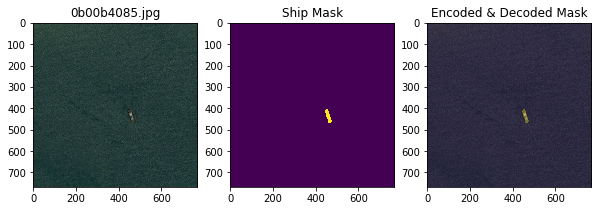

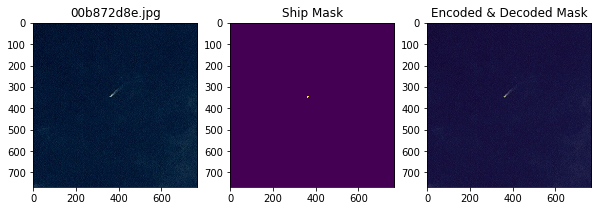

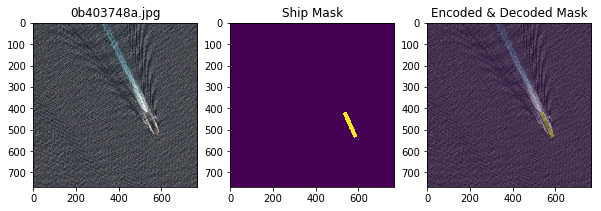

In [6]:
def rle_encode(img):
    '''
    run length encoding:
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    '''
    # reshape to 1d array
    pixels = img.T.flatten() # Needed to align to RLE direction
    # pads the head & the tail with 0 & converts to ndarray
    pixels = np.concatenate([[0], pixels, [0]])
    # gets all start(0->1) & end(1->0) positions 
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    # transforms end positions to lengths
    runs[1::2] -= runs[::2]
    # converts to the string formated: '[s0] [l0] [s1] [l1]...'
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=SHAPE):
    '''
    mask_rle: run-length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    shape: (height,width) of array to return 
    Returns numpy array according to the shape, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    # gets starts & lengths 1d arrays 
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    # gets ends 1d array
    ends = starts + lengths
    # creates blank mask image 1d array
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    # sets mark pixles
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # reshape as a 2d mask image
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, shape=SHAPE):
    '''
    Take the individual ship masks and create a single mask array for all ships
    in_mask_list: pd Series: [idx0] [RLE string0]...
    Returns numpy array as (shape.h, shape.w, 1)
    '''
    all_masks = np.zeros(shape, dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def display_decode_encode(image_id, path=TRAIN_DATA_PATH):
    '''
    Show image, ship mask, and encoded/decoded result
    '''
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))

    # image
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    
    # input mask
    rle_1 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    
    # encode & decode mask 
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()

# inspects a few example
display_decode_encode('0b00b4085.jpg')
display_decode_encode('00b872d8e.jpg')
display_decode_encode('0b403748a.jpg')

ImageId  ships                                        RleMaskList
49063  4160141d8.jpg      2  [294819 6 295581 12 296349 12 297117 12 297885...
26608  236ff6f43.jpg      1  [117888 1 118655 3 119421 6 120188 7 120955 9 ...
72805  60d90ab43.jpg      1  [289686 1 290452 4 291218 6 291984 9 292750 11...

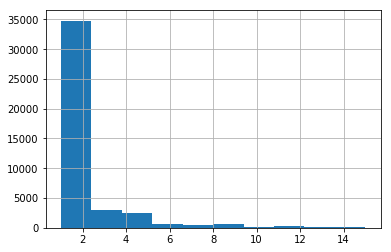

In [7]:
# Check if a mask has a ship
masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)

# Create the unique image id/rle_mask list
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()

# Image with ships
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

34044 training masks
8512 validation masks


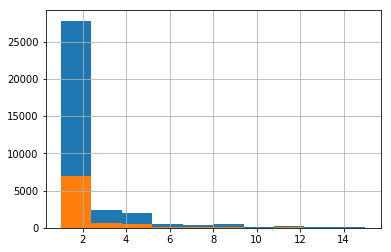

In [8]:
# Split the dataset to training & validation set

from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(unique_img_ids, 
                                      test_size=TRAINING_VALIDATION_RATIO, 
                                      stratify=unique_img_ids['ships'])
train_ids['ships'].hist()
val_ids['ships'].hist()

print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')

In [9]:
'''
Import Mask RCNN
'''

sys.path.append(MASK_RCNN_PATH)

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log 

Using TensorFlow backend.


In [10]:
class ASDCDataset(utils.Dataset):
    """
    Airbus Ship Detection Challenge (ASDC) Dataset
    """
    def __init__(self, image_file_dir, ids, masks, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT):
        super().__init__(self)
        self.image_file_dir = image_file_dir
        self.ids = ids
        self.masks = masks
        self.image_width = image_width
        self.image_height = image_height
        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()
        
    def load_dataset(self):
        """
        Load dataset from the path
        """
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)

    def load_mask(self, image_id):
        """
        Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count], dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        """
        Return the path of the image
        """
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

In [11]:
class ASDCGPUConfig(Config):
    """
    Configuration of Airbus Ship Detection Challenge Dataset 
    
    Overrides values in the base Config class.
    From https://github.com/samlin001/Mask_RCNN/blob/master/mrcnn/config.py
    """
    
    NAME = 'ASDC'

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    NUM_CLASSES = 2

    IMAGE_MIN_DIM = IMAGE_WIDTH
    IMAGE_MAX_DIM = IMAGE_WIDTH
    
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 50
    SAVE_BEST_ONLY = True
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.95

    # Non-maximum suppression threshold for detection
    # Keep it small to merge overlapping ROIs 
    DETECTION_NMS_THRESHOLD = 0.05

In [12]:
config = ASDCGPUConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

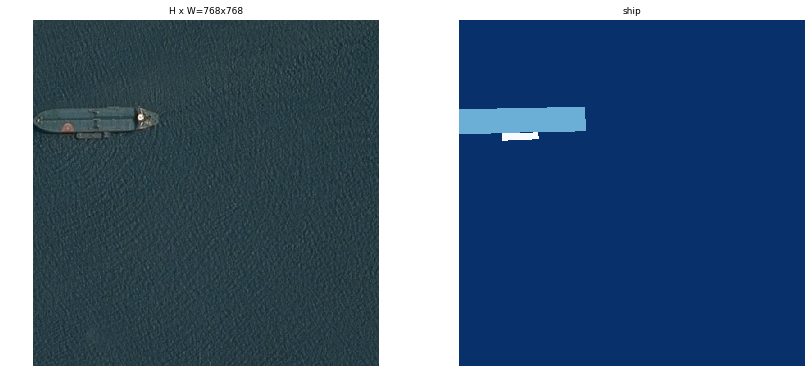

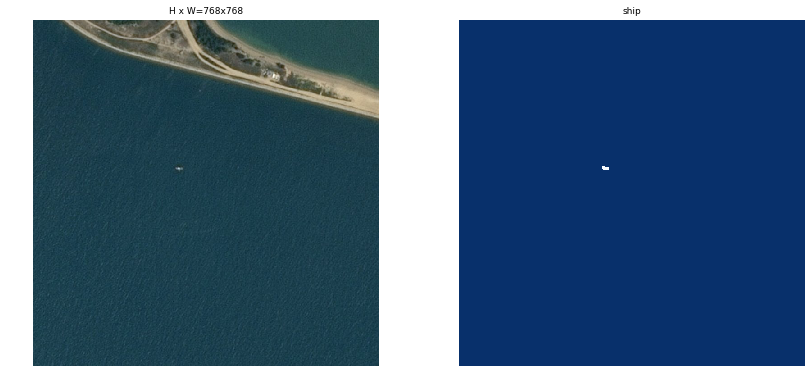

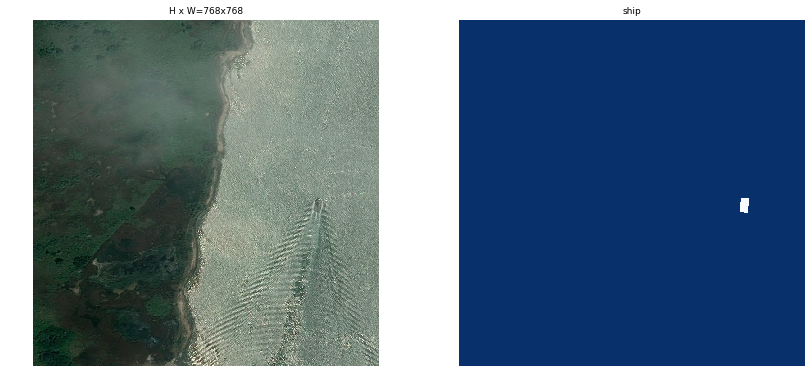

In [13]:
# Training dataset.
dataset_train = ASDCDataset(image_file_dir=TRAIN_DATA_PATH, ids=train_ids, masks=masks)
dataset_train.prepare()

# Validation dataset
dataset_val = ASDCDataset(image_file_dir=TRAIN_DATA_PATH, ids=val_ids, masks=masks)
dataset_val.prepare()

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

In [14]:
"""
Load the Mask-RCNN model weights.
"""
start_time = time.time()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=WORKING_DIR)

weights_path = COCO_WEIGHTS_PATH
utils.download_trained_weights(weights_path)
    
model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

end_time = time.time() - start_time
print("loading weights: {}".format(end_time))

Instructions for updating:
Colocations handled automatically by placer.
... done downloading pretrained model!
Loading weights:  /home/jupyter/mask_rcnn_coco.h5
loading weights: 113.89018726348877


In [15]:
"""
Train the model.
"""
import datetime

start_time = time.time()

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='all')

end_time = time.time() - start_time
print("Train model: {}".format(end_time))


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/jupyter/asdc20190518T2222/mask_rcnn_asdc_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Bat

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
300/300 [==============================] - 407s 1s/step - loss: 1.2268 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4409 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 0.2980 - val_loss: 1.3175 - val_rpn_class_loss: 0.0136 - val_rpn_bbox_loss: 0.4919 - val_mrcnn_class_loss: 0.0484 - val_mrcnn_bbox_loss: 0.4659 - val_mrcnn_mask_loss: 0.2977
Epoch 2/30
300/300 [==============================] - 350s 1s/step - loss: 1.0889 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4531 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2917 - mrcnn_mask_loss: 0.2898 - val_loss: 0.9911 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.5160 - val_mrcnn_class_loss: 0.0278 - val_mrcnn_bbox_loss: 0.1993 - val_mrcnn_mask_loss: 0.2386
Epoch 3/30
300/300 [==============================] - 351s 1s/step - loss: 1.0358 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3566 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.2939 - mrcnn_mask_loss: 0.3142 - val_loss: 1.4473 - val_rpn_class_l

In [16]:
class InferenceConfig(ASDCGPUConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

infer_model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=WORKING_DIR)
model_path = infer_model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
infer_model.load_weights(model_path, by_name=True)

# Test on a random image
# image_id = np.random.choice(dataset_val.image_ids)
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_val, inference_config, 
#                            image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))

# results = infer_model.detect([original_image], verbose=1)

# r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'])

Instructions for updating:
Use tf.cast instead.
Loading weights from  /home/jupyter/asdc20190518T2222/mask_rcnn_asdc_0030.h5
Re-starting from epoch 30


In [18]:
# image_ids = np.random.choice(dataset_val.image_ids, 20)
# APs = []
# inference_start = time.time()
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#         modellib.load_image_gt(dataset_val, inference_config,
#                                image_id, use_mini_mask=False)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = infer_model.detect([image], verbose=1)
#     r = results[0]
#     visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'])

#     # Compute AP
#     AP, precisions, recalls, overlaps =\
#         utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)

# inference_end = time.time()
# print('Inference Time: %0.2f Minutes'%((inference_end - inference_start)/60))
# print("mAP: ", np.mean(APs))

In [17]:
'''
Load the ASDC classifier to classifiying if an image contains ships or not.
'''
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

img_width = 768
img_height = 768

model = load_model('ASDCResNetClassifier.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
'''
Predicting images
'''

img = image.load_img('Data/input/test_v2/1cf417b95.jpg', target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images)
print(classes)

if(classes[0][1] > 0.80):
    print("has ship")
else:
    print("no ship")


[[0.8303678  0.16963217]]
no ship


In [20]:
from skimage import io
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Run detection
images_path = TEST_DATA_PATH
sample_sub_csv = SAMPLE_SUBMISSION_PATH
sample_submission_df = pd.read_csv(os.path.join(images_path,sample_sub_csv))
unique_image_ids = sample_submission_df.ImageId.unique()

out_pred_rows = []
count = 0

for image_id in unique_image_ids:
    image_path = os.path.join(images_path, image_id)
    if os.path.isfile(image_path):
        count += 1
        print("Step: ", count)

        # Start counting prediction time
        tic = time.clock()

        img = image.load_img(image_path, target_size=(256, 256))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])
        classes = model.predict(images)

        if(classes[0][1] > 0.80):
            img = io.imread(image_path)
            results = infer_model.detect([img], verbose=1)
            r = results[0]

            re_encoded_to_rle_list = []
            for i in np.arange(np.array(r['masks']).shape[-1]):
                boolean_mask = r['masks'][:,:,i]
                re_encoded_to_rle = rle_encode(boolean_mask)
                re_encoded_to_rle_list.append(re_encoded_to_rle)

            if len(re_encoded_to_rle_list) == 0:
                out_pred_rows += [{'ImageId': image_id, 'EncodedPixels': None}]
                print("Found Ship: ", "NO")
            else:
                for rle_mask in re_encoded_to_rle_list:
                    out_pred_rows += [{'ImageId': image_id, 'EncodedPixels': rle_mask}]
                    print("Found Ship: ", rle_mask)            
        else:
            out_pred_rows += [{'ImageId': image_id, 'EncodedPixels': None}]

        toc = time.clock()
        print("Prediction time: ",toc-tic)
            
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]

filename = "{}{:%Y%m%dT%H%M}.csv".format("submission_", datetime.datetime.now())
submission_df.to_csv(filename, index=False)

Step:  1
Prediction time:  0.0386160000007294
Step:  2
Prediction time:  0.03852900000038062
Step:  3
Prediction time:  0.033540000000357395
Step:  4
Prediction time:  0.035989999999401334
Step:  5
Prediction time:  0.03686999999990803
Step:  6
Prediction time:  0.038558999999622756
Step:  7
Prediction time:  0.03248799999983021
Step:  8
Prediction time:  0.03172600000016246
Step:  9
Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  133.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  768.00000  int64
anchors                  shape: (1, 147312, 4)        min:   -0.47202  max:    1.38858  float32
Found Ship:  184575 8 185337 20 186102 27 186868 32 187635 35 188402 38 189170 40 189937 43 190705 45 191473 48 192241 49 193009 51 193777 53 194544 57 195312 58 196080 60 196848 63 197616 66 198384 68 199152 70 1

In [21]:
filename = "{}{:%Y%m%dT%H%M}.csv".format("submission_", datetime.datetime.now())
submission_df.to_csv(filename, index=False)

In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm

INPUT = filename
OUTPUT = 'submission_final.csv'

def get_mask(img_id, df, shape = (768,768)):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    px = df.loc[img_id]['EncodedPixels']
    if(type(px) == float): return None
    elif(type(px) == str): px = [px]
    count = 1
    for mask in px:
        if(type(mask) == float):
            if len(px) == 1: return None
            else: continue
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = count*(img[start:start+length] == 0)
        count+=1
    return img.reshape(shape).T

def decode_mask(mask, shape=(768, 768)):
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    if(len(runs) == 0): return np.nan
    runs[runs > shape[0]*shape[1]] = shape[0]*shape[1]
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def set_masks(mask):
    n = mask.max()
    result = []
    for i in range(1,n+1):
        result.append(decode_mask(mask == i))
    return result

pred_df = pd.read_csv(INPUT).set_index('ImageId')
pred_df.head()

EncodedPixels
ImageId                    
00002bd58.jpg           NaN
00015efb6.jpg           NaN
00023d5fc.jpg           NaN
000367c13.jpg           NaN
0008ca6e9.jpg           NaN

In [23]:
names = list(set(pred_df.index))
ship_list_dict = []

for name in tqdm(names):
    mask = get_mask(name, pred_df)
    if (not isinstance(mask, np.ndarray) and mask == None) or mask.sum() == 0:
        ship_list_dict.append({'ImageId':name,'EncodedPixels':np.nan})
    else:
        encodings = set_masks(mask)
        if(len(encodings) == 0):
            ship_list_dict.append({'ImageId': name,'EncodedPixels': np.nan})
            continue
        
        buf =[]
        for e in encodings:
            if e == e: 
                buf.append(e)
        
        encodings = buf
        if len(encodings) == 0: 
            encodings = [np.nan]
       
        for encoding in encodings:
            ship_list_dict.append({'ImageId':name,'EncodedPixels':encoding})

100%|██████████| 15606/15606 [00:10<00:00, 1498.33it/s]


In [24]:
pred_df_cor = pd.DataFrame(ship_list_dict)
pred_df_cor.to_csv(OUTPUT, index=False)